In [1]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/home/liyuxuan/miniconda3/envs/huggingface/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
print(inputs)

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}


In [3]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)

In [4]:
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)

torch.Size([2, 16, 768])


Transformers 模块的矢量输出通常较大。它通常有三个维度：

- Batch size（批次大小）：一次处理的序列数（在我们的示例中为 2）。
- Sequence length（序列长度）：表示序列（句子）的长度（在我们的示例中为 16）。
- Hidden size（隐藏层大小）：每个模型输入的向量维度。

In [5]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)

模型头：理解数字的意义
Transformers 模型的输出会直接发送到模型头进行处理。

模型头通常由一个或几个线性层组成，它的输入是隐状态的高维向量，它会并将其投影到不同的维度。
在此图中，模型由其嵌入层和后续层表示。嵌入层将 tokenize 后输入中的每个 inputs ID 转换为表示关联 token 的向量。后续层使用注意机制操纵这些向量，生成句子的最终表示。

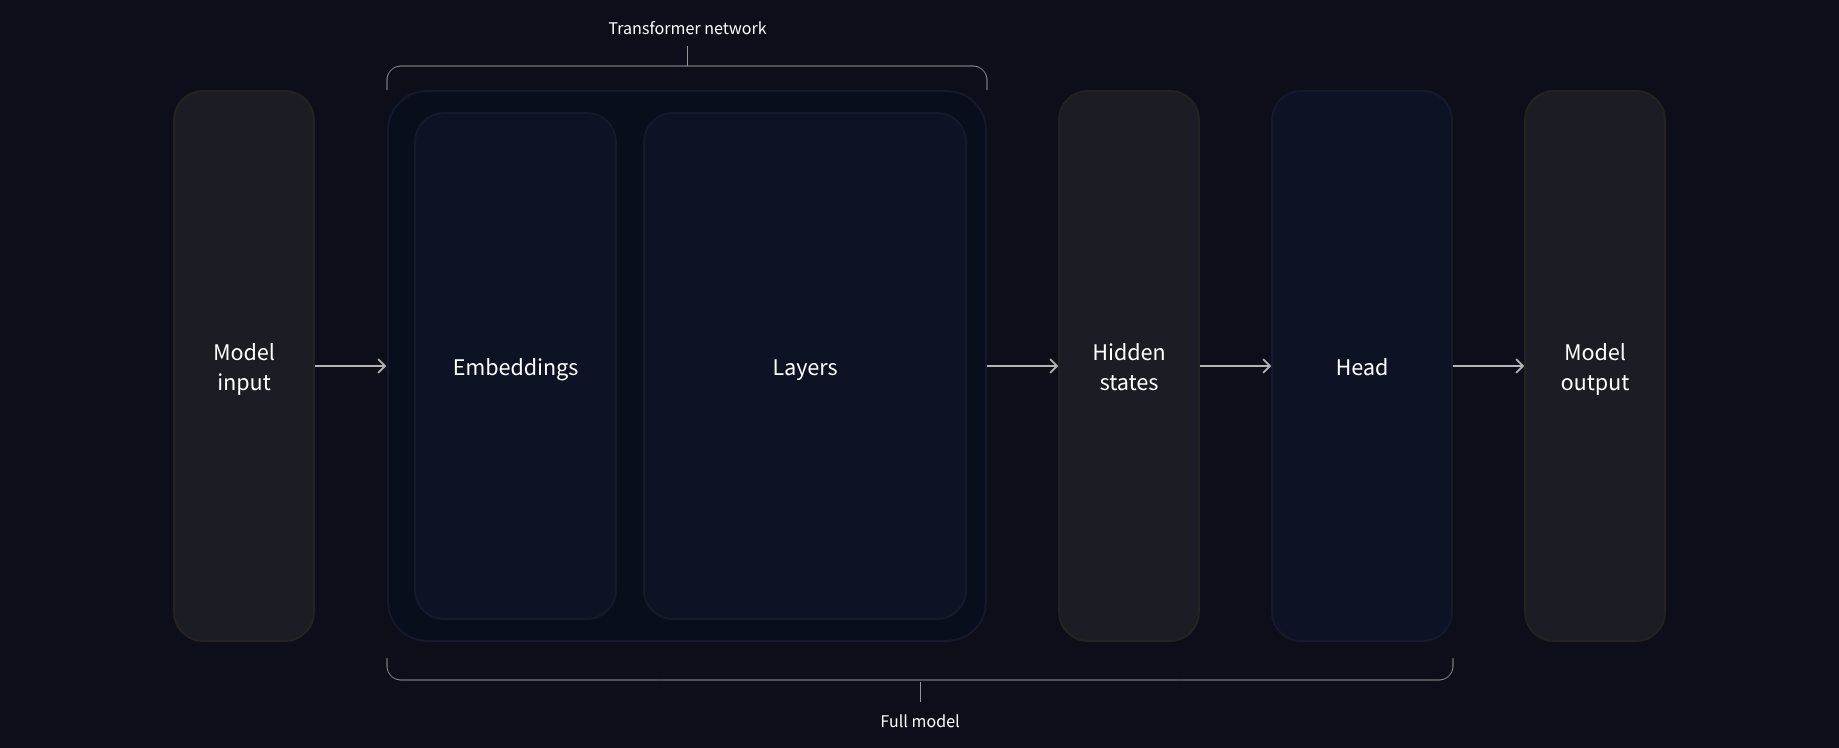

A Transformer network alongside its head.




In [6]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)

如果我们看一下现在输出的形状，其维度会降低很多：模型头接收我们之前看到的高维向量作为输入，并输出包含两个值（每种标签一个）的向量。正如您所见，输出向量的尺寸与输入向量相比要小得多。这是因为模型头将输入向量中的信息压缩成两个值，每个标签一个.

In [8]:
print(outputs.logits.shape)
print(outputs.logits)

torch.Size([2, 2])
tensor([[-1.5607,  1.6123],
        [ 4.1692, -3.3464]], grad_fn=<AddmmBackward0>)


所有🤗Transformers 模型的输出都是 logits，因为训练时的损失函数通常会将最后的激活函数（如 SoftMax）与实际的损失函数（如交叉熵）融合

In [9]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[4.0195e-02, 9.5980e-01],
        [9.9946e-01, 5.4418e-04]], grad_fn=<SoftmaxBackward0>)


为了获得每个分数对应的标签，我们可以查看模型配置的 id2label 属性（下一节将对此进行详细介绍），该属性将每个模型输出的 ID 映射到相应的标签：



In [10]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}